# 1. Introduction

This notebook aims to predict online shopper purchasing intention using various machine learning models. The dataset comes from the UCI Machine Learning Repository and contains behavioral and technical features for over 12,000 sessions.

#2. Data Loading and Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

#loading the dataset
csv = "online_shoppers_intention.csv"
df = pd.read_csv(csv)

# print the first row
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Initial Dataset Check (omitted in final report)
The dataset was verified for missing values and data types using `df.info()` and `df.describe()`, but this output is not included here for brevity.

In [ ]:
#checking the distribution of the target variable
df['Revenue'].value_counts(normalize=True)
#We can see they have unbalanced data, 0.845 False for 0.155 True

,proportion
Revenue,
False,0.845255
True,0.154745


#Preprocessing
The first step in our preprocessing pipeline is to ensure that all variables used for modeling
are in a numerical format. This is a critical requirement for most machine learning algorithms,
especially tree-based models such as Random Forest and XGBoost, which do not natively handle
categorical or boolean features.

We start by:
- Mapping the 'Month' feature to its corresponding numerical value (Jan=1, ..., Dec=12).
- Mapping the 'VisitorType' feature to integers (Returning_Visitor=2, New_Visitor=1, Other=0).
- Converting boolean columns such as 'Revenue' and 'Weekend' into integers (True → 1, False → 0).

These transformations ensure that all input features are numerical and ready to be fed into ML models.

### Mapping categorical and boolean features to numerical values

In [ ]:
# Define a mapping from month and visitor to numeric order
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

visitor_map = {
    'Returning_Visitor': 0,
    'New_Visitor': 1,
    'Other': 2
}


# Apply the mapping
df_processed = df.copy()
#print(df_processed.columns)
df_processed['Month'] = df_processed['Month'].map(month_map)
df_processed['VisitorType'] = df['VisitorType'].map(visitor_map)
# Convert boolean columns to integers
df_processed['Revenue'] = df_processed['Revenue'].astype(int)
df_processed['Weekend'] = df_processed['Weekend'].astype(int)
# Check result
#df_processed[['Month']].head()
#df_processed.head()
#df_processed.info()

### Visualizing the impact of PageValues on Revenue

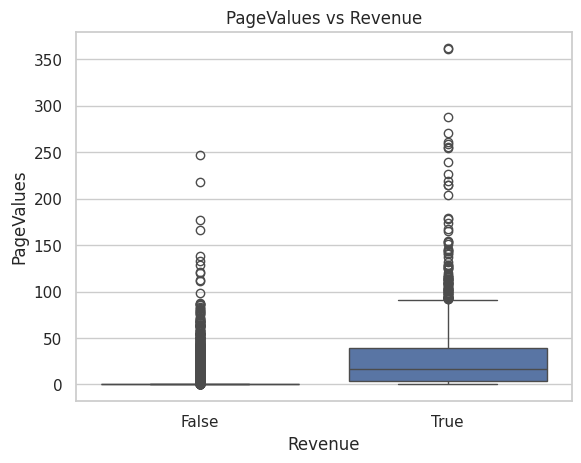

In [ ]:
# Boxplot for numerical variable
sns.boxplot(x='Revenue', y='PageValues', data=df)
plt.title('PageValues vs Revenue')
plt.show()

### Correlation analysis: filtering only features with |corr| ≥ 0.05 with Revenue


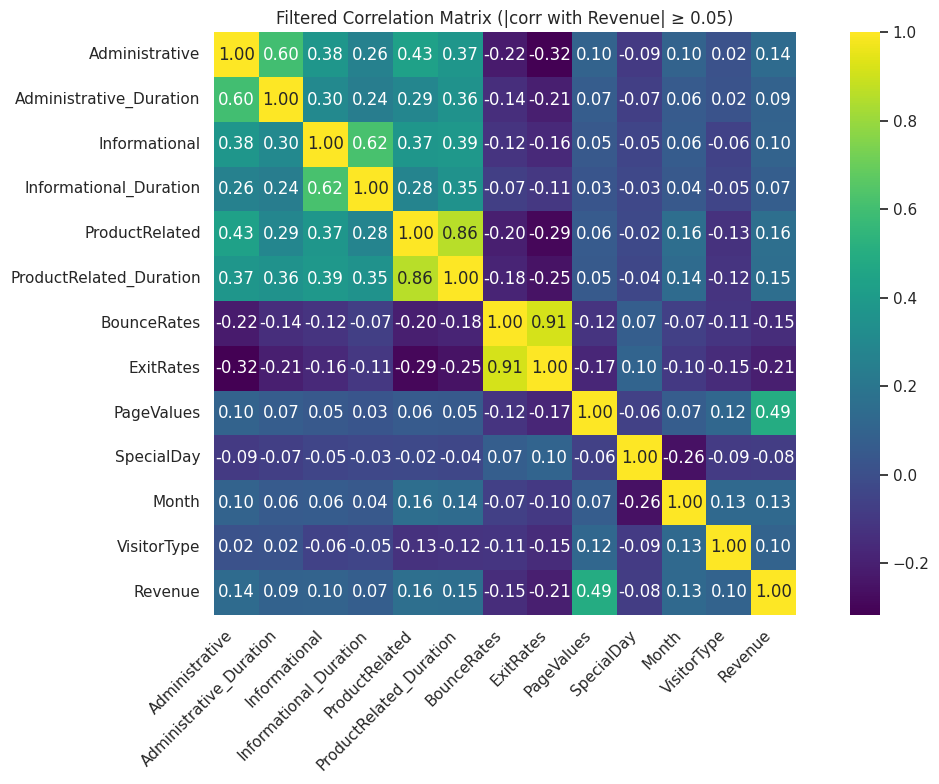

In [ ]:

# Compute correlation matrix
corr_matrix = df_processed.corr(numeric_only=True)

# Filter columns that have correlation ≥ 0.05 (absolute value) with 'Revenue'
target_corr = corr_matrix['Revenue'].abs()
cols_to_keep = target_corr[target_corr >= 0.05].index

# Filter the full matrix to keep only those columns/rows
filtered_corr = corr_matrix.loc[cols_to_keep, cols_to_keep]

# Plot the filtered heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="viridis", square=True, annot_kws={"size": 12})  # Increase font size and change colormap
plt.title('Filtered Correlation Matrix (|corr with Revenue| ≥ 0.05)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Train/Test Split — Full Feature Set

We start by defining our `X` and `y` from the full preprocessed dataset. This includes all 17 numerical features.  
We then split the data into training and test sets (80/20), stratifying on the target variable to preserve class imbalance in both subsets.

In [ ]:
from sklearn.model_selection import train_test_split
# Full feature set
X = df_processed.drop(columns=['Revenue'])
y = df_processed['Revenue']

# Check shape and class distribution
print("Original feature set")
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


Original feature set
X shape: (12330, 17)
y distribution:
 Revenue
0    0.845255
1    0.154745
Name: proportion, dtype: float64


### Train/Test Split — Selected Features

To evaluate whether a reduced set of informative features can yield similar performance, we repeat the same process but only using a subset of 10 features selected through correlation filtering and multicollinearity analysis.


In [ ]:
# Selected features based on correlation and collinearity analysis
selected_features = [
    'Administrative',
    'Administrative_Duration',
    'Informational',
    'Informational_Duration',
    'ProductRelated',
    'BounceRates',
    'PageValues',
    'SpecialDay',
    'Month',
    'VisitorType'
]

X_f = df_processed[selected_features]
y_f = df_processed['Revenue']

# Check shape and class distribution
print("Selected feature set")
print("X_f shape:", X_f.shape)
print("y_f distribution:\n", y_f.value_counts(normalize=True))

# Train/Test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_f, y_f, stratify=y_f, test_size=0.2, random_state=42
)



Selected feature set
X_f shape: (12330, 10)
y_f distribution:
 Revenue
0    0.845255
1    0.154745
Name: proportion, dtype: float64


#Logistic Regresssion

##Logistic Regression – With Hyperparameter Tuning
We first train a Logistic Regression model with a grid search to find the best hyperparameters. The search is conducted using 5-fold cross-validation and optimizes for recall, which is critical for minimizing false negatives (i.e., missed buyers).

In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score, f1_score
import numpy as np

# Pipeline: standardization + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500))
])

# Hyperparameter grid for logistic regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__penalty': ['l2'],  # 'l1' works only with 'liblinear'
    'clf__class_weight': [
        'balanced',           # built-in way to handle imbalanced data
        {0: 1, 1: 2},          # custom weight for positive class
        {0: 1, 1: 3}
    ]
}

# Use StratifiedKFold to maintain class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search to maximize recall (important due to imbalance)
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid.fit(X_train, y_train)

# Best model info
print("\nBest parameters:", grid.best_params_)
print(f"Best recall (CV - from grid search): {grid.best_score_:.3f}")

# Additional: Re-evaluate recall on best estimator with CV
cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring='recall')
print(f"Recall CV scores: {np.round(cv_scores, 3)}")
print(f"Mean recall (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Evaluate best model on test set
y_pred = grid.predict(X_test)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nRecall (Test set): {test_recall:.3f}")
print(f"F1-score (Test set): {test_f1:.3f}")
print("\nFull classification report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best recall (CV - from grid search): 0.747
Recall CV scores: [0.768 0.796 0.796 0.696 0.681]
Mean recall (CV): 0.747 ± 0.049

Recall (Test set): 0.743
F1-score (Test set): 0.628

Full classification report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      5211
           1       0.54      0.74      0.63       954

    accuracy                           0.86      6165
   macro avg       0.75      0.81      0.77      6165
weighted avg       0.89      0.86      0.87      6165



##Logistic Regression – With Feature Selection
We now apply the same pipeline on a reduced feature set (selected via correlation analysis). This allows us to evaluate whether compact models can achieve similar performance while reducing training time.

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

# Grid search with stratified CV
grid = GridSearchCV(pipe, param_grid, scoring='recall', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_f, y_train_f)

#Best parameters
print("Best parameters:", grid.best_params_)
print(f"Best recall (CV - from grid search): {grid.best_score_:.3f}")

#Cross-validation scores on best estimator
cv_scores = cross_val_score(grid.best_estimator_, X_train_f, y_train_f, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores, 3))
print(f"Mean recall (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

#Evaluate on test set
y_pred_f = grid.predict(X_test_f)
test_recall = recall_score(y_test_f, y_pred_f)
test_f1 = f1_score(y_test_f, y_pred_f)

print(f"\nRecall (Test set): {test_recall:.3f}")
print(f" F1-score (Test set): {test_f1:.3f}")

#Full report
print("\nFull classification report:")
print(classification_report(y_test_f, y_pred_f))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best recall (CV - from grid search): 0.740
Recall CV scores: [0.734 0.748 0.711 0.755 0.751]
Mean recall (CV): 0.740 ± 0.016

Recall (Test set): 0.702
 F1-score (Test set): 0.613

Full classification report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      2084
           1       0.54      0.70      0.61       382

    accuracy                           0.86      2466
   macro avg       0.74      0.80      0.76      2466
weighted avg       0.88      0.86      0.87      2466



##Logistic Regression – With SMOTE Oversampling
Finally, we test whether SMOTE (Synthetic Minority Oversampling Technique) can improve performance by generating synthetic minority samples. We compare the F1-score to that of the class-weighted model.

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# Pipeline: SMOTE + scaling + logistic regression
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500))
])

# Hyperparameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__penalty': ['l2'],
    'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

# GridSearchCV setup
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid.fit(X_train, y_train)

# Display best parameters and CV recall
print("Best parameters:", grid.best_params_)
print(f"Best recall (CV - from grid search): {grid.best_score_:.3f}")

# Additional CV scores on best model
cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores, 3))
print(f"Mean recall (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Evaluate on test set
y_pred = grid.predict(X_test)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nRecall (Test set): {test_recall:.3f}")
print(f"F1-score (Test set): {test_f1:.3f}")

# Full classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'clf__C': 0.01, 'clf__class_weight': {0: 1, 1: 3}, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best recall (CV - from grid search): 0.883
Recall CV scores: [0.902 0.879 0.879 0.869 0.885]
Mean recall (CV): 0.883 ± 0.011

Recall (Test set): 0.853
F1-score (Test set): 0.430

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      2084
           1       0.29      0.85      0.43       382

    accuracy                           0.65      2466
   macro avg       0.62      0.73      0.59      2466
weighted avg       0.85      0.65      0.70      2466



#Random Forest

##Random Forest - Baseline (Full Features)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Base model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

# Grid search
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_rf.fit(X_train, y_train)

# Best parameters and recall from grid search
print("Best parameters:", grid_rf.best_params_)
print(f"Best recall (CV - from grid search): {grid_rf.best_score_:.3f}")

# Cross-validation recall on best estimator
cv_scores_rf = cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores_rf, 3))
print(f"Mean recall (CV): {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")

# Evaluate on test set
y_pred_rf = grid_rf.predict(X_test)
test_recall_rf = recall_score(y_test, y_pred_rf)
test_f1_rf = f1_score(y_test, y_pred_rf)

print(f"\nRecall (Test set): {test_recall_rf:.3f}")
print(f"F1-score (Test set): {test_f1_rf:.3f}")

# Full classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best recall (CV - from grid search): 0.788
Recall CV scores: [0.803 0.784 0.787 0.775 0.79 ]
Mean recall (CV): 0.788 ± 0.009

Recall (Test set): 0.759
F1-score (Test set): 0.655

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2084
           1       0.58      0.76      0.65       382

    accuracy                           0.88      2466
   macro avg       0.76      0.83      0.79      2466
weighted avg       0.89      0.88      0.88      2466



#With feature selection

In [ ]:

# Base model with feature selection
rf_f = RandomForestClassifier(random_state=42)

# Grid search
grid_fs = GridSearchCV(
    estimator=rf_f,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on reduced feature set
grid_fs.fit(X_train_f, y_train_f)

# Best grid search result
print("Best parameters:", grid_fs.best_params_)
print(f"Best recall (CV - from grid search): {grid_fs.best_score_:.3f}")

# Cross-validation recall scores on best estimator
cv_scores_fs = cross_val_score(grid_fs.best_estimator_, X_train_f, y_train_f, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores_fs, 3))
print(f"Mean recall (CV): {cv_scores_fs.mean():.3f} ± {cv_scores_fs.std():.3f}")

# Evaluation on test set
y_pred_fs = grid_fs.predict(X_test_f)
test_recall_fs = recall_score(y_test_f, y_pred_fs)
test_f1_fs = f1_score(y_test_f, y_pred_fs)

print(f"\nRecall (Test set): {test_recall_fs:.3f}")
print(f"F1-score (Test set): {test_f1_fs:.3f}")

# Full classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test_f, y_pred_fs))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best recall (CV - from grid search): 0.796
Recall CV scores: [0.807 0.797 0.777 0.804 0.797]
Mean recall (CV): 0.796 ± 0.010

Recall (Test set): 0.762
F1-score (Test set): 0.660

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2084
           1       0.58      0.76      0.66       382

    accuracy                           0.88      2466
   macro avg       0.77      0.83      0.79      2466
weighted avg       0.90      0.88      0.88      2466



#With smote

In [ ]:
# Define pipeline with SMOTE and Random Forest
pipeline_rf_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_smote = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__class_weight': ['balanced']
}

# Stratified cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_rf_smote = GridSearchCV(
    pipeline_rf_smote,
    param_grid=param_grid_smote,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train
grid_rf_smote.fit(X_train, y_train)

# Best results
print("Best parameters:", grid_rf_smote.best_params_)
print(f"Best recall (CV - from grid search): {grid_rf_smote.best_score_:.3f}")

# Cross-validation recall scores on best estimator
cv_scores_smote = cross_val_score(grid_rf_smote.best_estimator_, X_train, y_train, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores_smote, 3))
print(f"Mean recall (CV): {cv_scores_smote.mean():.3f} ± {cv_scores_smote.std():.3f}")

# Test set evaluation
y_pred_smote = grid_rf_smote.predict(X_test)
test_recall_smote = recall_score(y_test, y_pred_smote)
test_f1_smote = f1_score(y_test, y_pred_smote)

print(f"\nRecall (Test set): {test_recall_smote:.3f}")
print(f"F1-score (Test set): {test_f1_smote:.3f}")

# Classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_smote))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best recall (CV - from grid search): 0.811
Recall CV scores: [0.82  0.816 0.8   0.824 0.797]
Mean recall (CV): 0.811 ± 0.011

Recall (Test set): 0.775
F1-score (Test set): 0.649

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2084
           1       0.56      0.77      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.78      2466
weighted avg       0.89      0.87      0.88      2466



##Feature Importance

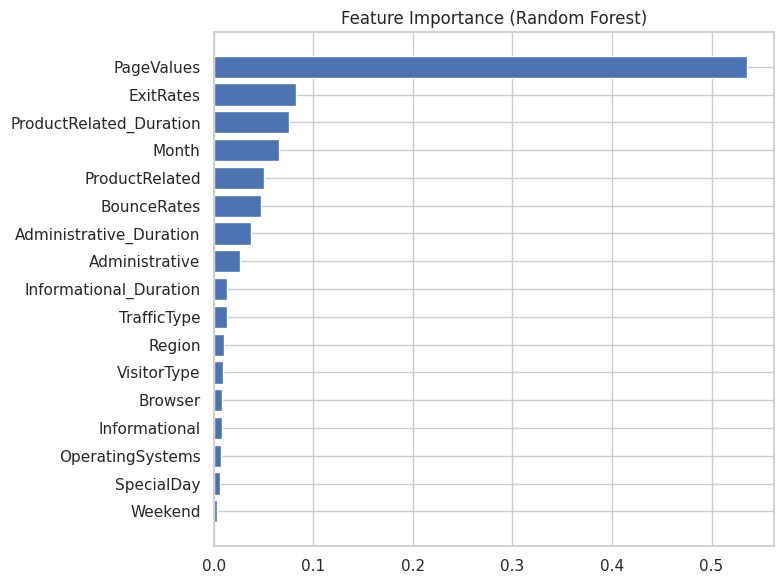

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances_rf = grid_rf.best_estimator_.feature_importances_
features = X_train.columns
rf_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


#XG boost




In [ ]:
from xgboost import XGBClassifier

# Handle class imbalance using scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Base XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Grid Search with recall as scoring metric
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,  # Stratified CV defined earlier
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_xgb.fit(X_train, y_train)

# Best result
print("Best parameters:", grid_xgb.best_params_)
print(f"Best recall (CV - from grid search): {grid_xgb.best_score_:.3f}")

# Cross-validation recall scores on best estimator
cv_scores_xgb = cross_val_score(grid_xgb.best_estimator_, X_train, y_train, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores_xgb, 3))
print(f"Mean recall (CV): {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")

# Test set evaluation
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

test_recall_xgb = recall_score(y_test, y_pred_xgb)
test_f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"\nRecall (Test set): {test_recall_xgb:.3f}")
print(f"F1-score (Test set): {test_f1_xgb:.3f}")

# Classification report
print("\nXGBoost - Classification Report on Test Set:")
print(classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best recall (CV - from grid search): 0.841


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall CV scores: [0.859 0.83  0.83  0.876 0.81 ]
Mean recall (CV): 0.841 ± 0.024

Recall (Test set): 0.830
F1-score (Test set): 0.647

XGBoost - Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91      2084
           1       0.53      0.83      0.65       382

    accuracy                           0.86      2466
   macro avg       0.75      0.85      0.78      2466
weighted avg       0.90      0.86      0.87      2466



#Feature Importance

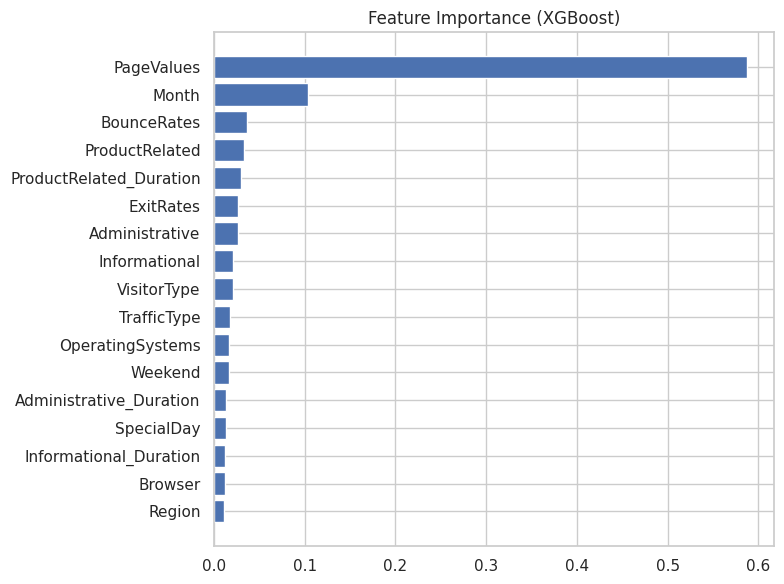

In [ ]:
importances_xgb = best_xgb.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'])
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

#With feature selection

In [ ]:
# Recalculate imbalance ratio on filtered data
scale_pos_weight_f = y_train_f.value_counts()[0] / y_train_f.value_counts()[1]

# Same base model adapted to the filtered dataset
xgb_f = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_f,
    random_state=42,
    n_jobs=-1
)

# Reuse the same hyperparameter grid
grid_xgb_f = GridSearchCV(
    estimator=xgb_f,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit on filtered training set
grid_xgb_f.fit(X_train_f, y_train_f)

# Results
print("Best parameters:", grid_xgb_f.best_params_)
print(f"Best recall (CV - from grid search): {grid_xgb_f.best_score_:.3f}")

# Cross-validation recall scores on best estimator
cv_scores_xgb_f = cross_val_score(grid_xgb_f.best_estimator_, X_train_f, y_train_f, cv=cv, scoring='recall')
print("Recall CV scores:", np.round(cv_scores_xgb_f, 3))
print(f"Mean recall (CV): {cv_scores_xgb_f.mean():.3f} ± {cv_scores_xgb_f.std():.3f}")

# Test set evaluation
best_xgb_f = grid_xgb_f.best_estimator_
y_pred_xgb_f = best_xgb_f.predict(X_test_f)

test_recall_xgb_f = recall_score(y_test_f, y_pred_xgb_f)
test_f1_xgb_f = f1_score(y_test_f, y_pred_xgb_f)

print(f"\nRecall (Test set): {test_recall_xgb_f:.3f}")
print(f"F1-score (Test set): {test_f1_xgb_f:.3f}")

# Classification report
print("\nXGBoost (selected features) - Classification Report on Test Set:")
print(classification_report(y_test_f, y_pred_xgb_f))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best recall (CV - from grid search): 0.842


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall CV scores: [0.843 0.846 0.823 0.873 0.826]
Mean recall (CV): 0.842 ± 0.018

Recall (Test set): 0.838
F1-score (Test set): 0.643

XGBoost (selected features) - Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2084
           1       0.52      0.84      0.64       382

    accuracy                           0.86      2466
   macro avg       0.74      0.85      0.78      2466
weighted avg       0.90      0.86      0.87      2466



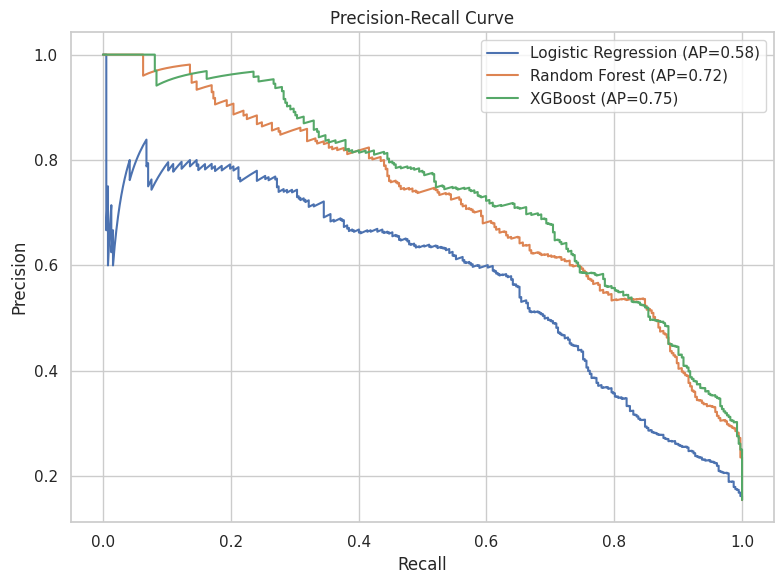

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

models = {
    'Logistic Regression': grid.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f'{name} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [24]:
from tabpfn import TabPFNClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, f1_score

# Train/test split (50/50 comme les autres tests pour TabPFN)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# Initialisation et entraînement du modèle TabPFN
model = TabPFNClassifier()
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Évaluation finale
test_recall_tabpfn = recall_score(y_test, y_pred)
test_f1_tabpfn = f1_score(y_test, y_pred)

print(f"Recall (Test set): {test_recall_tabpfn:.3f}")
print(f"F1-score (Test set): {test_f1_tabpfn:.3f}")

# Rapport complet
print("\nTabPFN - Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:89: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Recall (Test set): 0.630
F1-score (Test set): 0.670

TabPFN - Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5211
           1       0.72      0.63      0.67       954

    accuracy                           0.90      6165
   macro avg       0.83      0.79      0.81      6165
weighted avg       0.90      0.90      0.90      6165



## Final Model Selection

After testing multiple models and strategies (feature selection, SMOTE, grid search), the best performing model is:

**XGBoost (with selected features)**  
→ Recall (class 1): 0.84  
→ F1-score (class 1): 0.64  
→ Accuracy: 0.86

This model achieves the best balance between precision and recall while remaining robust and interpretable.